### ***Dataset Collection***


In [ ]:
! pip install kaggle
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download odins0n/ucf-crime-dataset

100% 11.0G/11.0G [10:32<00:00, 19.8MB/s]
100% 11.0G/11.0G [10:32<00:00, 18.7MB/s]


In [ ]:
!unzip '/content/ucf-crime-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [ ]:
train_dir="/content/Train"
test_dir="/content/Test"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Conv2D,Flatten
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
LR= 0.00003

In [ ]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [ ]:
crimes={}
train=test=0
for clss in crime_types:
  num=len(os.listdir(os.path.join(train_dir,clss)))

  train+=num

  test+=len(os.listdir(os.path.join(test_dir,clss)))

  crimes [clss]=num

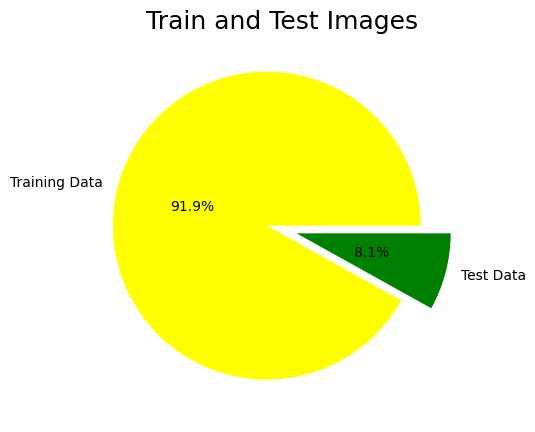

In [ ]:
plt.figure(figsize=(8, 5))
plt.pie(x=np.array([train, test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5,colors=[ 'yellow', 'green'])
plt.title("Train and Test Images", fontsize=18);

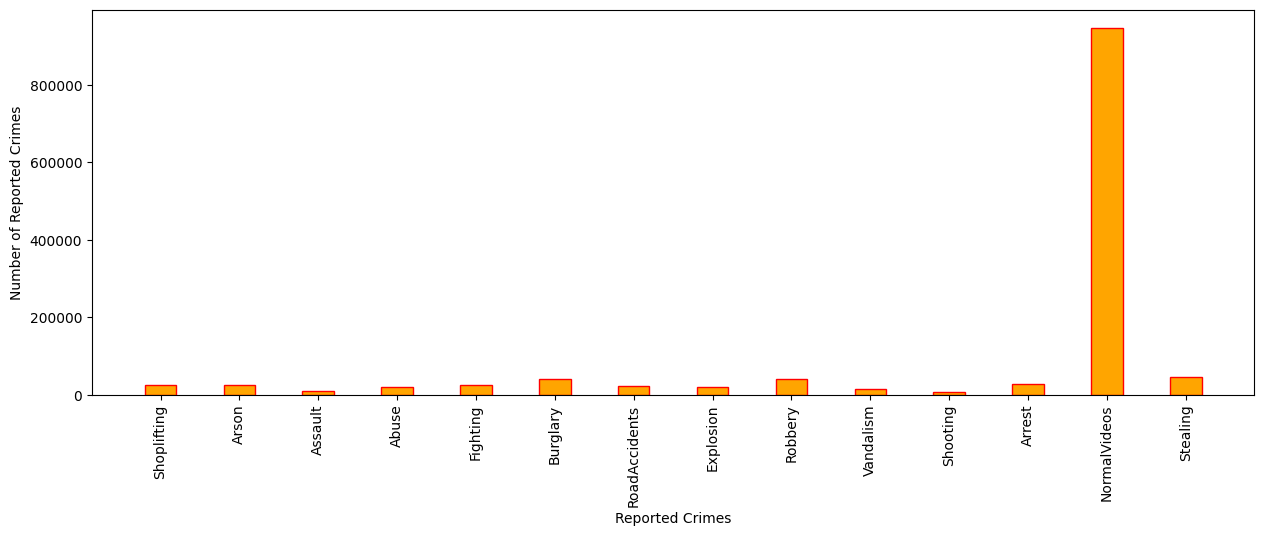

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4, align="center", edgecolor=['red'],color=['orange'])
plt.xticks(rotation=90)
plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [ ]:
IMG_SHAPE=IMG_HEIGHT, IMG_WIDTH

In [ ]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [ ]:
val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [ ]:
test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=SEED,
)

Found 111308 files belonging to 14 classes.


In [ ]:
def transfer_learning():
  base_model=DenseNet121(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3), weights="imagenet")
  thr=149
  for layers in base_model.layers[:thr]:
    layers.trainable=False
  for layers in base_model.layers[thr:]:
    layers.trainable=False
  return base_model

In [ ]:
def create_model():
  model=Sequential()
  base_model=transfer_learning()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout (0.2))
  model.add(Dense (512, activation="relu"))
  model.add(Dropout (0.2))
  model.add(Dense (1024, activation="relu"))
  model.add(Dense (n, activation="softmax"))
  model.summary()
  return model

In [ ]:
model=create_model()
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [ ]:
history=model.fit(x=train_set,validation_data=val_set,epochs=EPOCHS)

Epoch 1/5
7915/7915 [==============================] - 1481s 184ms/step - loss: 0.3355 - accuracy: 0.9080 - val_loss: 0.1133 - val_accuracy: 0.9685
Epoch 2/5
7915/7915 [==============================] - 1366s 172ms/step - loss: 0.1846 - accuracy: 0.9485 - val_loss: 0.0810 - val_accuracy: 0.9784
Epoch 3/5
7915/7915 [==============================] - 1362s 172ms/step - loss: 0.1606 - accuracy: 0.9564 - val_loss: 0.0638 - val_accuracy: 0.9830
Epoch 4/5
7915/7915 [==============================] - 1378s 174ms/step - loss: 0.1463 - accuracy: 0.9612 - val_loss: 0.0636 - val_accuracy: 0.9833
Epoch 5/5
7622/7915 [===========================>..] - ETA: 41s - loss: 0.1394 - accuracy: 0.9636

In [ ]:
#save model
model.save('crime.h5')

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('crime.h5')
y_true=np.array([])
for x,y in test_set:
  y_true=np.concatenate([y_true,np.argmax(y.numpy(),axis=-1)])
  y_pred=model.predict(test_set)

In [ ]:
y_pred

In [ ]:
y_true

In [ ]:
#testing 1
img=image.load_img('',target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
pred=np.argmax(model.predict(x))
op=['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred]